In [30]:
from IPython.display import display
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns
import m8r

In [44]:
datapath='/home/ivan/Documents/pmfd3d/examples/SEAM_Foothills_P2/'
traceZavm = m8r.Input(datapath+'traceZ2.rsf')
o1=traceZavm.float('o1')
d1=traceZavm.float('d1')
n1=traceZavm.int('n1')
o2=traceZavm.float('o2')
d2=traceZavm.float('d2')
n2=traceZavm.int('n2')
o4=traceZavm.float('o4')
d4=traceZavm.float('d4')
n4=traceZavm.int('n4')
data = traceZavm.read(shape=(n2,n1)).T
time = np.arange(o1,o1+n1*d1,d1)
offset = (np.arange(o2,o2+n2*d2,d2) - o4)*1e3
print(np.shape(data))

(1000, 501)


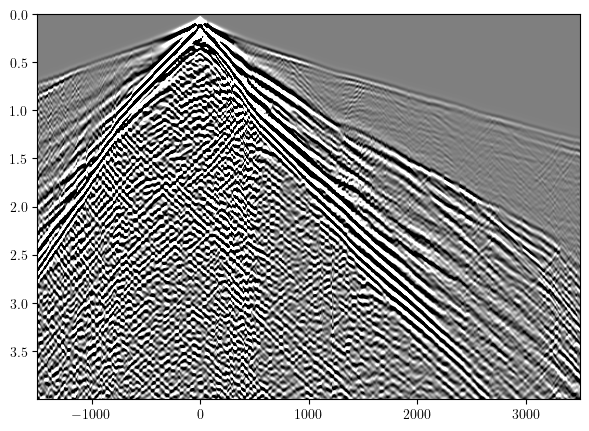

In [126]:
plt.rcParams['figure.figsize'] = [7, 5]
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
clip=1e-4
plt.imshow(data, cmap='gray', vmin=-clip, vmax=clip, origin='upper', aspect='auto',
           extent=[offset[0], offset[-1], time[-1], time[0]])


In [46]:
# Create an xarray Dataset
shot_gather = xr.DataArray(
    data.T, 
    dims=["offset", "time"],  # Names for each dimension
    coords={"time": time, "offset": offset},  # Coordinates for each dimension
)

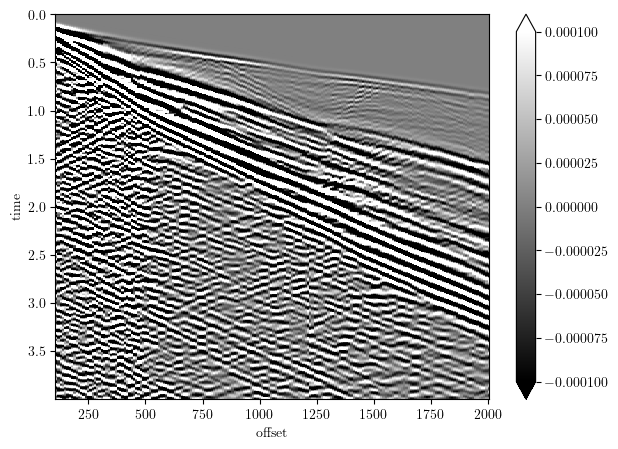

In [127]:
iof=100
fof=2000
shot_gatherr= shot_gather.where((shot_gather.offset>iof ) & (shot_gather.offset<fof ), drop=True)
shot_gatherr.plot.imshow('offset','time',cmap='gray', vmin=-clip, vmax=clip, origin='upper')

Text(0, 0.5, 'Phase velocity (m/s)')

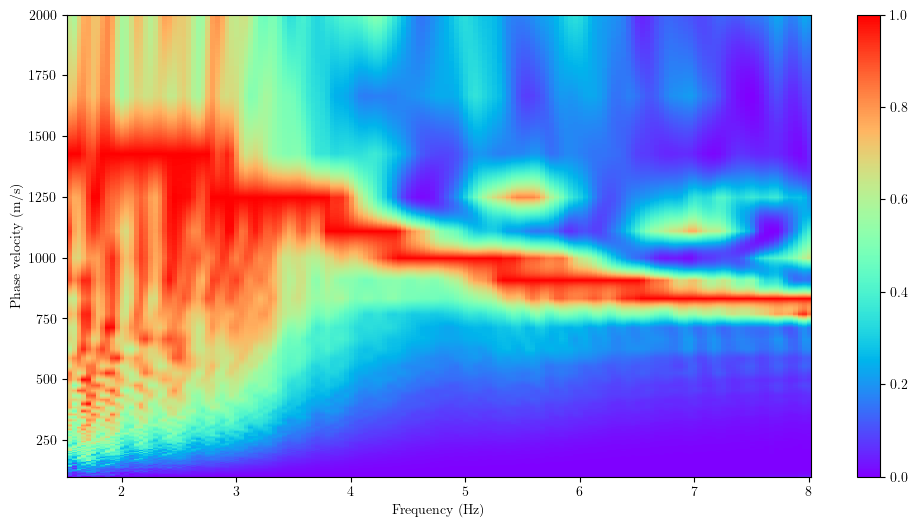

In [158]:
import masw_functions as mf
vmin=100.0 
vmax=2001.0
fmin=1.5
fmax=8.0
pstep=10e-5
Nf=6001
v=np.arange(vmin,vmax)
D=mf.DispersionSpectrum(shot_gather,v,fmin,fmax,Nf,pstep)
plt.rcParams['figure.figsize'] = [12, 6]
D.plot.imshow(D.dims[1],D.dims[0],cmap='rainbow', origin='lower')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity (m/s)")

/home/ivan/Documents/SW_Inversion_3D_Data/masw_functions.py:348: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ind = Xobs.groupby(['freq'])['amp'].transform(max) == Xobs['amp']


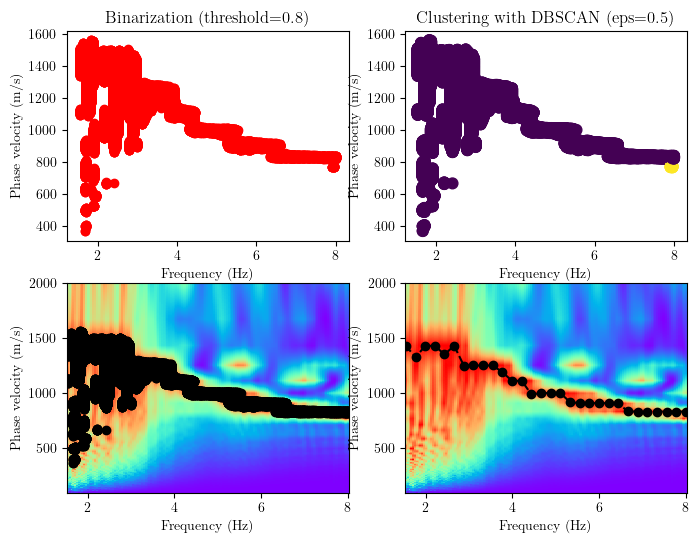

In [176]:
num=30
Xobs=mf.AutomaticPicking(D,threshold=0.9,eps=0.5,num=num,fig=True, reg=False,color='rainbow')

Text(0, 0.5, 'Depth (m)')

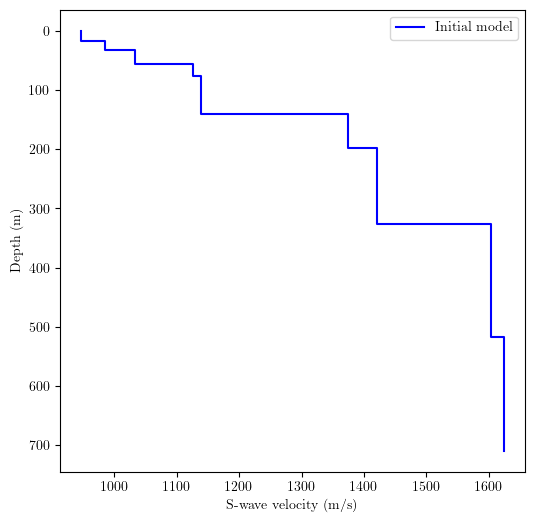

In [177]:
Nh=10
(vsia,hia,zia)=mf.InitialModel(Xobs,Nh)
plt.rcParams['figure.figsize'] = [6, 6]
plt.figure()
plt.step(np.append(vsia,vsia[-1]),zia,label='Initial model',color='blue')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("S-wave velocity (m/s)")
plt.ylabel("Depth (m)")

Text(0, 0.5, 'Depth (m)')

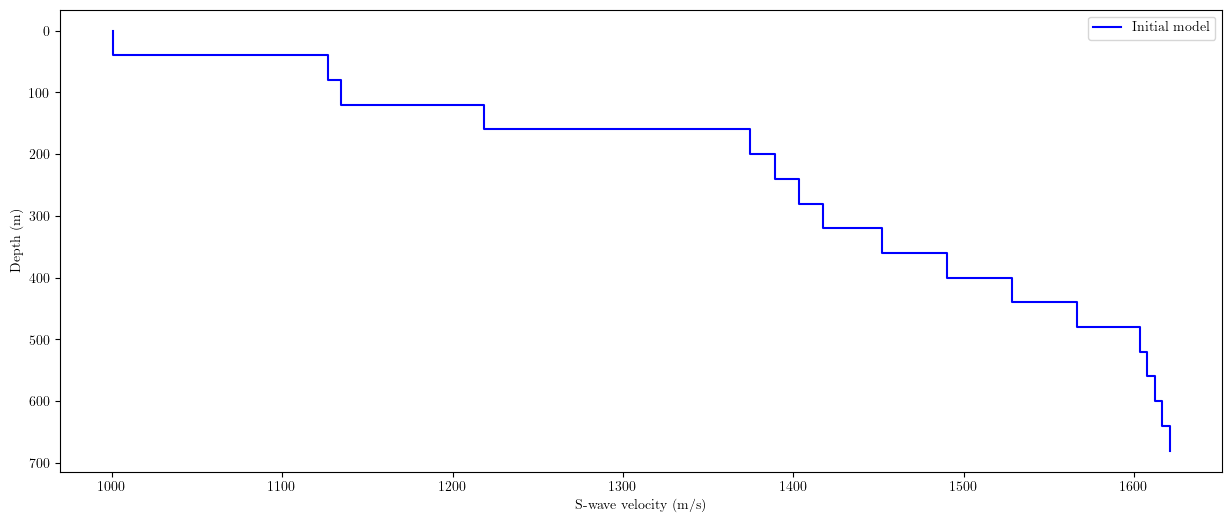

In [183]:
from scipy.interpolate import interp1d
ht = 40
vsz = interp1d(zia,np.append([0],vsia))
zi = np.arange(0,zia[-1],ht)
hi = np.diff(zi[1:])
vsi = vsz(zi[1:])
plt.figure()
plt.step(np.append(vsi,vsi[-1]),zi,label='Initial model',color='blue')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("S-wave velocity (m/s)")
plt.ylabel("Depth (m)")

  0%|          | 0/20 [00:00<?, ?it/s]

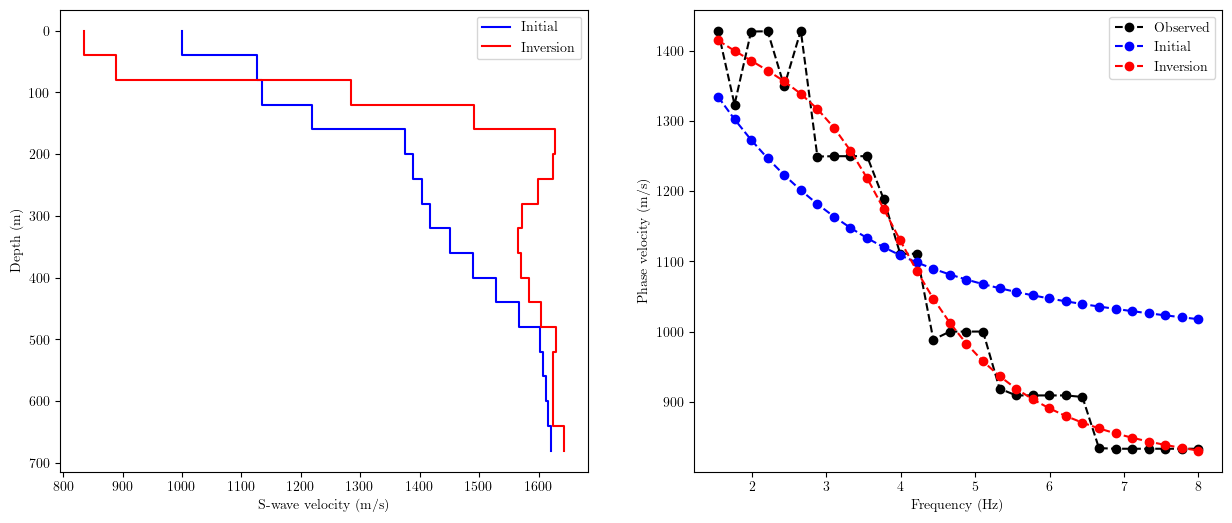

In [184]:
rps=2.5
alpha=num
n_iter=20
rhoi=2*np.ones(np.size(vsi))
dh=8
(vsf,vpf,error)=mf.sw_inversion(Xobs[:,1],Xobs[:,0],vsi,rhoi,hi,rps,n_iter,alpha,dh)

plt.rcParams['figure.figsize'] = [15, 6]
fig, axs = plt.subplots(1,2)
axs[0].step(np.append(vsi,vsi[-1]),zi, color='blue', label='Initial')
axs[0].step(np.append(vsf,vsf[-1]),zi, color='red', label='Inversion')
axs[0].set(xlabel='S-wave velocity (m/s)', ylabel='Depth (m)')
axs[0].legend()
axs[0].invert_yaxis()

cRi=mf.forward_dispersion(vsi,rps*vsi,rhoi,hi,Xobs[:,0])
cRf=mf.forward_dispersion(vsf,rps*vsf,rhoi,hi,Xobs[:,0])
axs[1].plot(Xobs[:,0], Xobs[:,1], 'o--', color='black', label='Observed')
axs[1].plot(Xobs[:,0], cRi, 'o--', color='blue', label='Initial')
axs[1].plot(Xobs[:,0], cRf, 'o--', color='red', label='Inversion')
axs[1].set(xlabel='Frequency (Hz)', ylabel='Phase velocity (m/s)')
axs[1].legend()

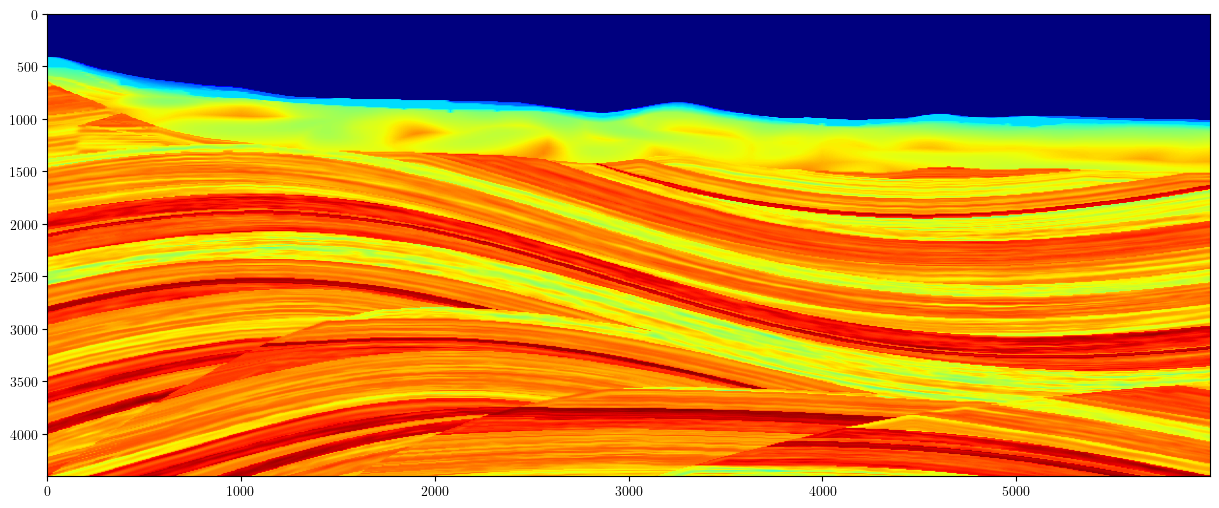

In [93]:
mvs = m8r.Input(datapath+'Vs_100.rsf')
o1=mvs.float('o1')
d1=mvs.float('d1')
n1=mvs.int('n1')
o2=mvs.float('o2')
d2=mvs.float('d2')
n2=mvs.int('n2')
vstrue = mvs.read(shape=(n2,n1)).T
zaxis = np.arange(o1,o1+n1*d1,d1)*1e3
xaxis = np.arange(o2,o2+n2*d2,d2)*1e3

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.imshow(vstrue, cmap='jet', origin='upper', aspect='auto',
           extent=[xaxis[0], xaxis[-1], zaxis[-1], zaxis[0]])

Text(0, 0.5, 'Depth (m)')

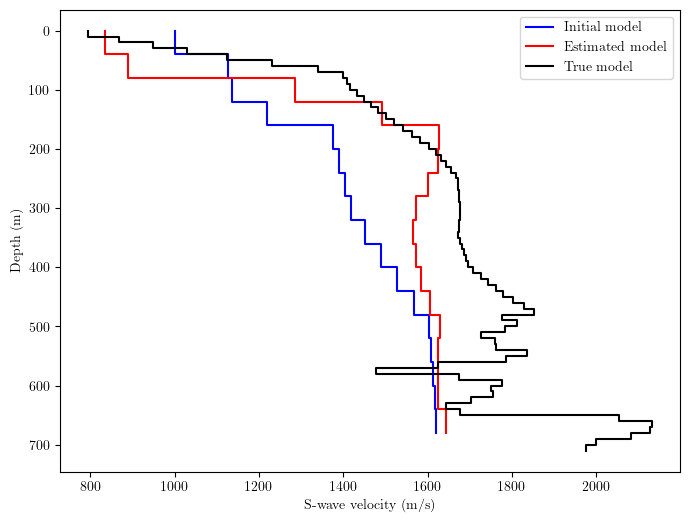

In [189]:
plt.rcParams['figure.figsize'] = [8, 6]
vst=vstrue[99:170,370]*1e3
zt = np.append(0,zaxis[99:170]-zaxis[98])
plt.figure()
plt.step(np.append(vsi,vsi[-1]),zi,label='Initial model',color='blue')
plt.step(np.append(vsf,vsf[-1]),zi,label='Estimated model',color='red')
plt.step(np.append(vst,vst[-1]),zt,label='True model',color='black')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("S-wave velocity (m/s)")
plt.ylabel("Depth (m)")